In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import pprint
from boto.s3.connection import S3Connection
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import pylab as pl
import numpy as np
from scipy import misc

%matplotlib inline

# Limit rows disp# Limit rows displayed in notebook
pd.set_option('display.max_rows', 20)
pd.set_option('display.precision', 2)
plt.rcParams['figure.figsize'] = 20, 12 

Getting business and review data

In [2]:
import json
import pandas
 
def convertBusiness(x):
    ob = json.loads(x)
    for k, v in ob.items():
        if isinstance(v, list):
            ob[k] = ','.join(v)
        elif isinstance(v, dict):
            for kk, vv in v.items():
                ob['%s_%s' % (k, kk)] = vv
            del ob[k]
    return ob

def convertReviews(x):
    ''' Convert a json string to a flat python dictionary
    which can be passed into Pandas. '''
    ob = json.loads(x)
    return {"business_id":ob["business_id"], "stars":ob["stars"], "date":ob["date"]}

def createPandas(func, json_filename):
    return pd.DataFrame([func(line) for line in file(json_filename)])

print "Creating Business Pandas"
pd_business = createPandas(convertBusiness,'yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_business.json')
print "Creating Review Pandas"
pd_review = createPandas(convertReviews, 'yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.json')
print "Completed Creating Pandas"

Creating Business Pandas
Creating Review Pandas
Completed Creating Pandas


Getting business and review data in Vegas

In [3]:
pd_business_lasvegas = pd_business[pd_business["city"] == "Las Vegas"]
pd_review_lasvegas = pd.merge(pd_business_lasvegas, pd_review, left_on='business_id', right_on='business_id', how='inner')

Geographic Clustering of Data

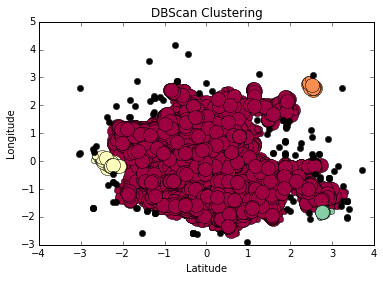

In [18]:
''' DBSCAN : Okayish results '''

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import numpy as np

business_lasvegas_latlong = pd_business_lasvegas[["latitude", "longitude"]].values.tolist()
X = StandardScaler().fit_transform(business_lasvegas_latlong)
db = DBSCAN(eps=0.2, min_samples=10).fit(X)
core_samples = db.core_sample_indices_
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)
colors = pl.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'k'
        markersize = 6
    class_members = [index[0] for index in np.argwhere(labels == k)]
    cluster_core_samples = [index for index in core_samples
                            if labels[index] == k]
    
    for index in class_members:
        x = X[index]
        if index in core_samples and k != -1:
            markersize = 14
        else:
            markersize = 6

        plt.plot(x[0], x[1], 'o', markerfacecolor=col,
                markeredgecolor='k', markersize=markersize)

plt.title("DBScan Clustering")        
plt.ylabel("Longitude")
plt.xlabel("Latitude")
plt.show()

@ Cluster  16


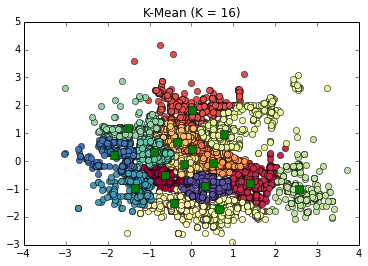

@ Cluster  17


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


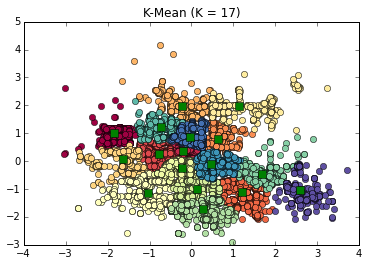

@ Cluster  18


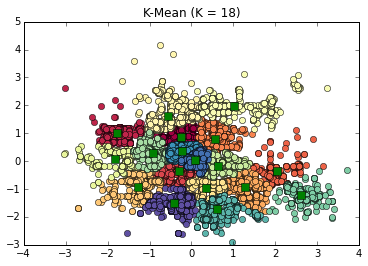

@ Cluster  19


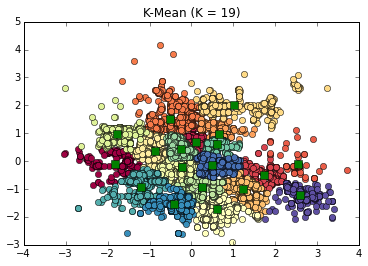

@ Cluster  20


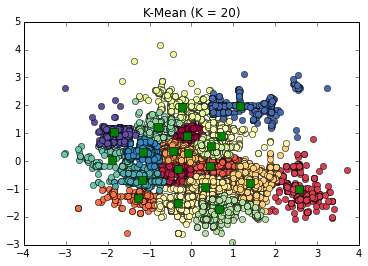

In [20]:
''' K Means with results '''

from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
from scipy.cluster.vq import kmeans,kmeans2, vq
import cPickle as pickle

business_lasvegas_latlong = pd_business_lasvegas[["latitude", "longitude"]].values.tolist()
X = StandardScaler().fit_transform(business_lasvegas_latlong)

for k in range(16, 21):
    print "@ Cluster ", k
    centroids, labels = kmeans2(X,k)
    idx,_ = vq(X,centroids)
    colors = pl.cm.Spectral(np.linspace(0, 1, k))
    for i in range(k):
        plt.plot(X[idx==i,0],X[idx==i,1], 'o', markerfacecolor=colors[i])
    plt.title('K-Mean (K = '+str(k)+")")
    plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=8)
    plt.show()
    pd_business_lasvegas['cluster'] = pd.Series(labels, index=pd_business_lasvegas.index)
    pd_review_lasvegas = pd.merge(pd_business_lasvegas, pd_review, left_on='business_id', right_on='business_id', how='inner')
    gb = pd_review_lasvegas.groupby(['business_id'])
    gb = gb.agg({'date' : np.min})
    gb["new"] = (gb["date"] >= "2011-01-01")
    pd_review_lasvegas = pd_review_lasvegas.set_index('business_id')
    pd_lasvegas = pd.merge(pd_review_lasvegas, gb, left_index=True, right_index=True, how='inner')
    pickle.dump( pd_lasvegas, open( "pd_lasvegas_"+str(k)+".pkl", "wb" ) )

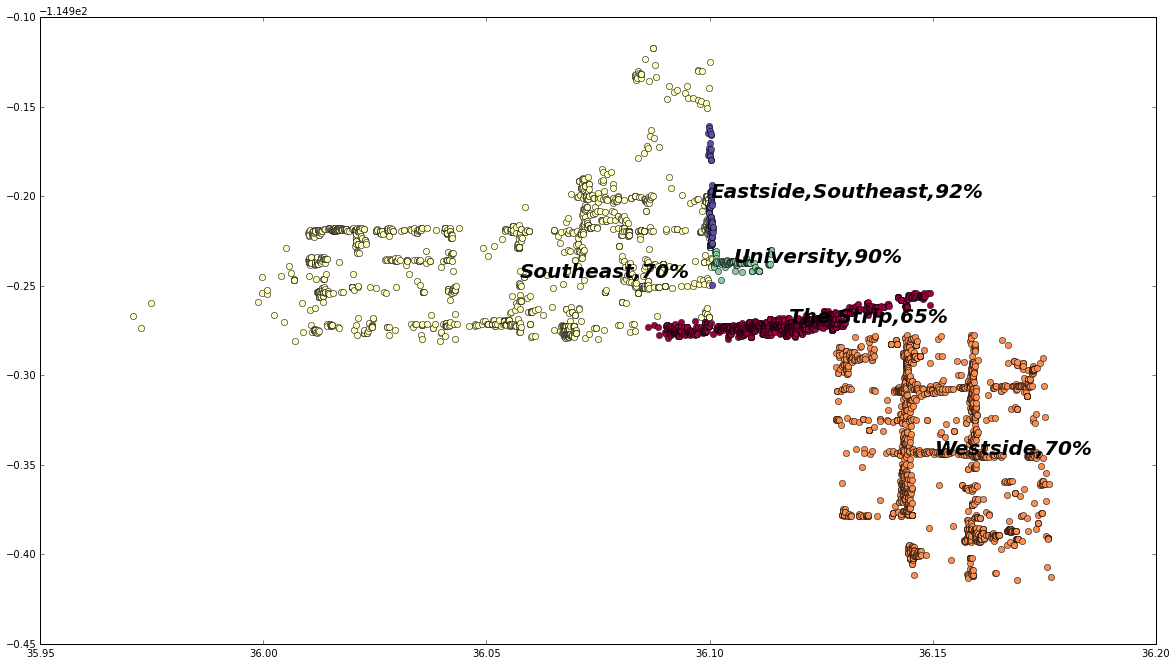

In [56]:
''' DBSCAN : Okayish results '''

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import numpy as np

neighbours = [     
            "The Strip",
            'Westside',
            'Southeast',
            'University',
            'Eastside,Southeast', 
      ]
val = [65, 70, 70, 90, 92 ]

fig = plt.figure()
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)

business_lasvegas = pd_business_lasvegas[["neighborhoods", "latitude", "longitude"]]
colors = pl.cm.Spectral(np.linspace(0, 1, len(neighbours)) )
for i, n in enumerate(neighbours):
    markersize, col, tmplist= 6, colors[i], business_lasvegas[business_lasvegas['neighborhoods'] == n].values.tolist()
    L = len(tmplist)
    tmplist = sorted(tmplist, key=lambda x: x[1])
    for idx, table in enumerate(tmplist):
        if idx == L/2:
            plt.text(table[1], table[2], n+","+str(val[i])+"%", style='oblique', fontsize=20,fontweight='bold')
        else:
            plt.plot(table[1], table[2], 'o', markerfacecolor=col, markeredgecolor='k', markersize=markersize)

plt.show()